# Determinare se un fungo e' commestibile o no

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Mauro Pellonara

## Descrizione del problema e analisi esplorativa

Si deve realizzare un modello che utilizzando i dati TODO.

Parlare della struttura e delle variabili contenute (magari menzionare che ho scelto questo invece che l'original e perche ha 3 valori continui). 

Nominare anche le cose spiegate nella descrizione e tutto.

Vengono importate le librerie necessarie per scaricare i file, organizzare le strutture dati, disegnare i grafici e sviluppare il modello.

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from os import path
from urllib.request import urlretrieve
from sklearn.preprocessing import OrdinalEncoder, Normalizer, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

Vengono impostate variabili generali che se modificate cambiano il modello e le scelte

In [56]:
json_config_filename = "knn_imputer_5_features.json"
with open(json_config_filename) as config_file:
    config = json.load(config_file)

    delete_rows_that_have_columns_with_many_nan = config["delete_rows_that_have_columns_with_many_nan"]
    delete_columns_that_have_many_nan = config["delete_columns_that_have_many_nan"]
    use_knn_imputer = config["use_knn_imputer"]
    normalize_data = config["normalize_data"]
    standardize_data = config["standardize_data"]
    k_best_features_to_select = config["k_best_features_to_select"]

### Caricamento dei dati

In [57]:
if not path.exists("mushrooms.csv"):
    urlretrieve("https://archive.ics.uci.edu/static/public/848/data.csv", "mushrooms.csv")

mushrooms = pd.read_csv("mushrooms.csv")

osserviamo

In [58]:
mushrooms.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


Di seguito sono riportate le dimensioni in memoria, il numero di istanze non nulle e il tipo delle feature che compongono i dati raccolti nel dataset (training set) 

In [59]:
mushrooms.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

### Spiegazione delle feature

Dataset: https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset

Riportiamo le informazioni sul dataset tratte dalla fonte

Dati di tipo categorico

Date timestamp della misurazione

Temperature misura della temperatura misurata in gradi centigradi (C°)

Humidity misura dell'umidità relativa in percentuale

Light misura della luminosità in Lux (lx)

CO2 misura di CO2 nell'aria in parti per milione (ppm)

Humidity_Ratio misura derivata dalla umidità e dalla temperatura in Kg di vapore acqueo in Kg di aria

Occupancy indica la presenza di persone nell'ufficio

1 = presenti (stato occupato) 0 = assenti (stato non occupato)
Con il metodo describe è possibile avere una rappresentazione statistica delle feature numeriche, ottenendo media, deviazione standard e la distribuzione in termini di massimi, minimi e percentili.

La temperatura è abbastanza stabile intorno ai 20 gradi centigradi, il che ci fa supporre che le misure siano state fatte in un luogo protetto, dove non ci sono troppi sbalzi di temperatura e/o le misurazioni siano limitate ad una certa parte dell'anno. I valori della umidità sono invece più variegati, se si mantengono le medesime considerazioni sulla temaperatura, si può attribuire tale fenomeno ad una maggiore sensibilità alla presenza o meno di persone nell'ufficio. Come per la temperatura non è chiaro se la luce sia influenzata da fattori ambientali, come l'alternarsi fra giorno e notte, le ore di luce che variano durante l'anno oppure artificiali come l'uso di luci elettriche. Il valore minimo in Lux corrisponde al completo buio, il massimo ad una giornata abbastanza luminosa, la distribuzione è abbastanza binaria, facendo ipotizzare misurazioni frequenti anche durante la notte con valori costantemente pari a zero. I valori di anidride carbonica in parti per milione potrebbero essere influenzati dall'inquinamento atmosferico o dalla vegetazione nei pressi dell'ufficio.

### Preprocessing

#### Casting e riduzione memoria
Specifichiamo tipi che sono boolean e rinomiamo in modo verboso la variabile target e osserviamo

In [60]:
mushrooms.rename(columns={"class": "is-edible"}, inplace=True)

mushrooms["is-edible"] = mushrooms["is-edible"].map({"p": False, "e": True})
mushrooms["does-bruise-or-bleed"] = mushrooms["does-bruise-or-bleed"].map({"t": True, "f": False})
mushrooms["has-ring"] = mushrooms["has-ring"].map({"t": True, "f": False})

mushrooms.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   is-edible             61069 non-null  bool   
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  bool   
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

encoding delle categorie e osserviamo

In [61]:
category_columns = mushrooms.select_dtypes(include="object").columns

encoder = OrdinalEncoder()
mushrooms[category_columns] = encoder.fit_transform(mushrooms[category_columns])

mushrooms.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   is-edible             61069 non-null  bool   
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  float64
 3   cap-surface           46949 non-null  float64
 4   cap-color             61069 non-null  float64
 5   does-bruise-or-bleed  61069 non-null  bool   
 6   gill-attachment       51185 non-null  float64
 7   gill-spacing          36006 non-null  float64
 8   gill-color            61069 non-null  float64
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   float64
 12  stem-surface          22945 non-null  float64
 13  stem-color            61069 non-null  float64
 14  veil-type             3177 non-null   float64
 15  veil-color         

guardiamo come sono i dati diventati

In [62]:
mushrooms.head()

,is-edible,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,False,15.26,6.0,2.0,6.0,False,2.0,NaN,10.0,16.95,...,4.0,7.0,11.0,0.0,4.0,True,2.0,NaN,0.0,3.0
1,False,16.60,6.0,2.0,6.0,False,2.0,NaN,10.0,17.99,...,4.0,7.0,11.0,0.0,4.0,True,2.0,NaN,0.0,2.0
2,False,14.07,6.0,2.0,6.0,False,2.0,NaN,10.0,17.80,...,4.0,7.0,11.0,0.0,4.0,True,2.0,NaN,0.0,3.0
3,False,14.17,2.0,3.0,1.0,False,2.0,NaN,10.0,15.77,...,4.0,7.0,11.0,0.0,4.0,True,5.0,NaN,0.0,3.0
4,False,14.64,6.0,3.0,6.0,False,2.0,NaN,10.0,16.53,...,4.0,7.0,11.0,0.0,4.0,True,5.0,NaN,0.0,3.0


describe perche si

In [63]:
mushrooms.describe()

,cap-diameter,cap-shape,cap-surface,cap-color,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,ring-type,spore-print-color,habitat,season
count,61069.000000,61069.000000,46949.000000,61069.000000,51185.000000,36006.000000,61069.000000,61069.000000,61069.000000,9531.000000,22945.000000,61069.000000,3177.0,7413.000000,58598.000000,6354.000000,61069.000000,61069.000000
mean,6.733854,4.041641,5.483077,6.144541,2.517437,0.411765,7.338502,6.581538,12.149410,2.074074,4.485334,8.429072,0.0,3.641306,1.468975,2.656437,0.623721,1.053300
std,5.264845,2.138630,3.277637,3.171077,2.184753,0.662046,3.186426,3.370017,10.035955,1.698147,2.035054,3.218516,0.0,1.045332,1.495966,1.934103,1.265880,1.100575
min,0.380000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.480000,2.000000,2.000000,5.000000,1.000000,0.000000,5.000000,4.640000,5.210000,0.000000,3.000000,6.000000,0.0,4.000000,1.000000,1.000000,0.000000,0.000000
50%,5.860000,5.000000,7.000000,5.000000,2.000000,0.000000,7.000000,5.950000,10.190000,2.000000,5.000000,11.000000,0.0,4.000000,1.000000,2.000000,0.000000,1.000000
75%,8.540000,6.000000,8.000000,10.000000,5.000000,1.000000,10.000000,7.740000,16.570000,4.000000,6.000000,11.000000,0.0,4.000000,1.000000,3.000000,1.000000,2.000000
max,62.340000,6.000000,10.000000,11.000000,6.000000,2.000000,11.000000,33.920000,103.910000,4.000000,7.000000,12.000000,0.0,5.000000,7.000000,6.000000,7.000000,3.000000


#### Visualizzazione grafica delle feature

Text(0, 0.5, 'Stem height')

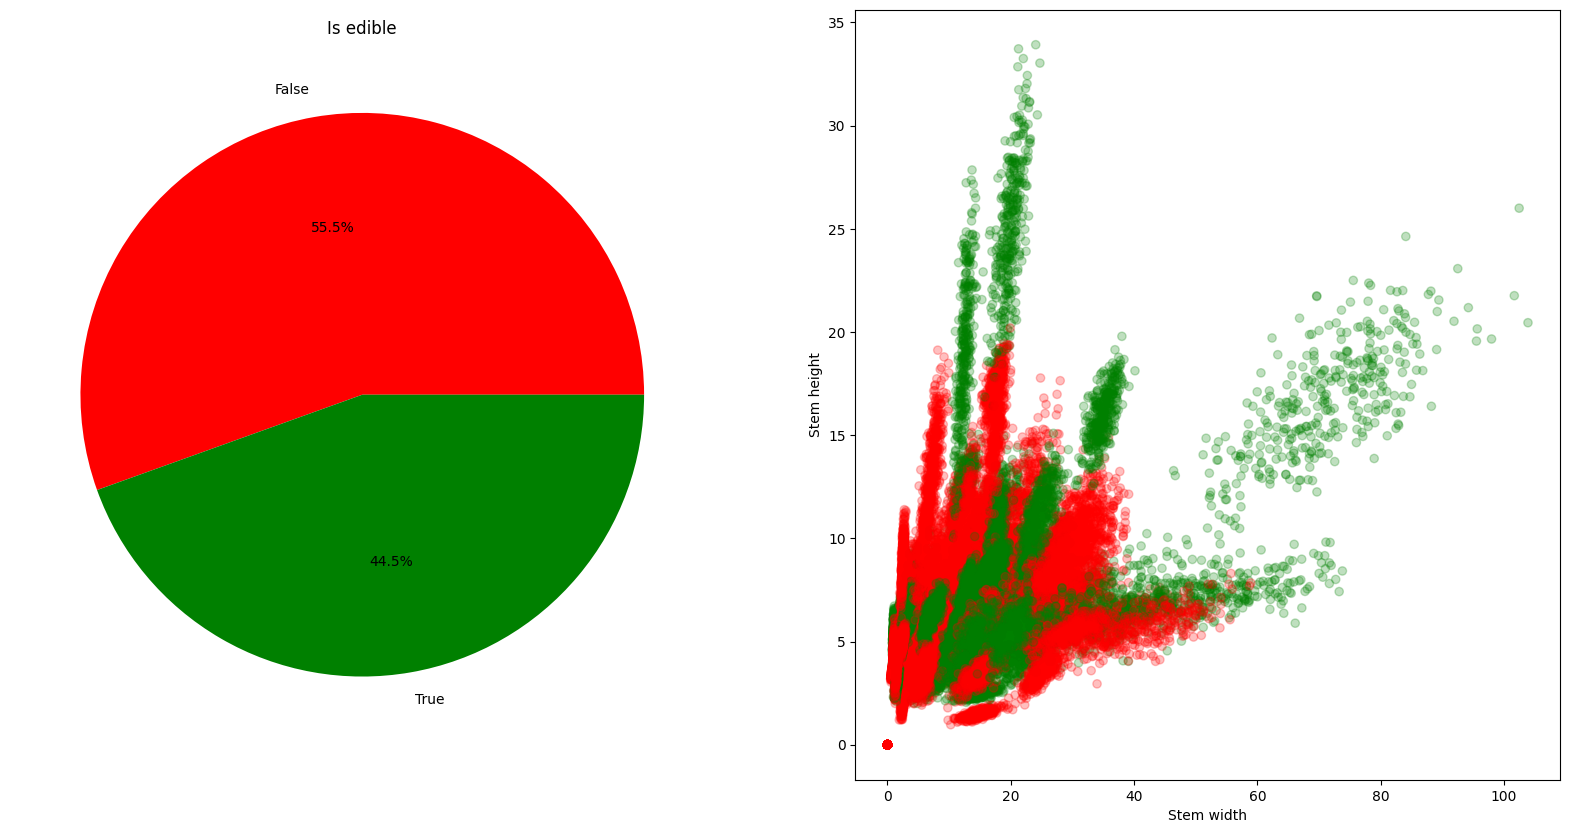

In [64]:
figsize = (20, 10)
is_edible_colors_map = {True: "green", False: "red"}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

mushrooms["is-edible"].value_counts().plot.pie(title="Is edible", colors=[is_edible_colors_map[False], is_edible_colors_map[True]], autopct="%1.1f%%", ylabel="", ax=axes[0])

axes[1].scatter(mushrooms["stem-width"], mushrooms["stem-height"], c=mushrooms["is-edible"].map(is_edible_colors_map), alpha=0.25)
axes[1].set_xlabel("Stem width")
axes[1].set_ylabel("Stem height")

stem basso w stretto con cap largo = vita

Text(0, 0.5, 'Cap diameter')

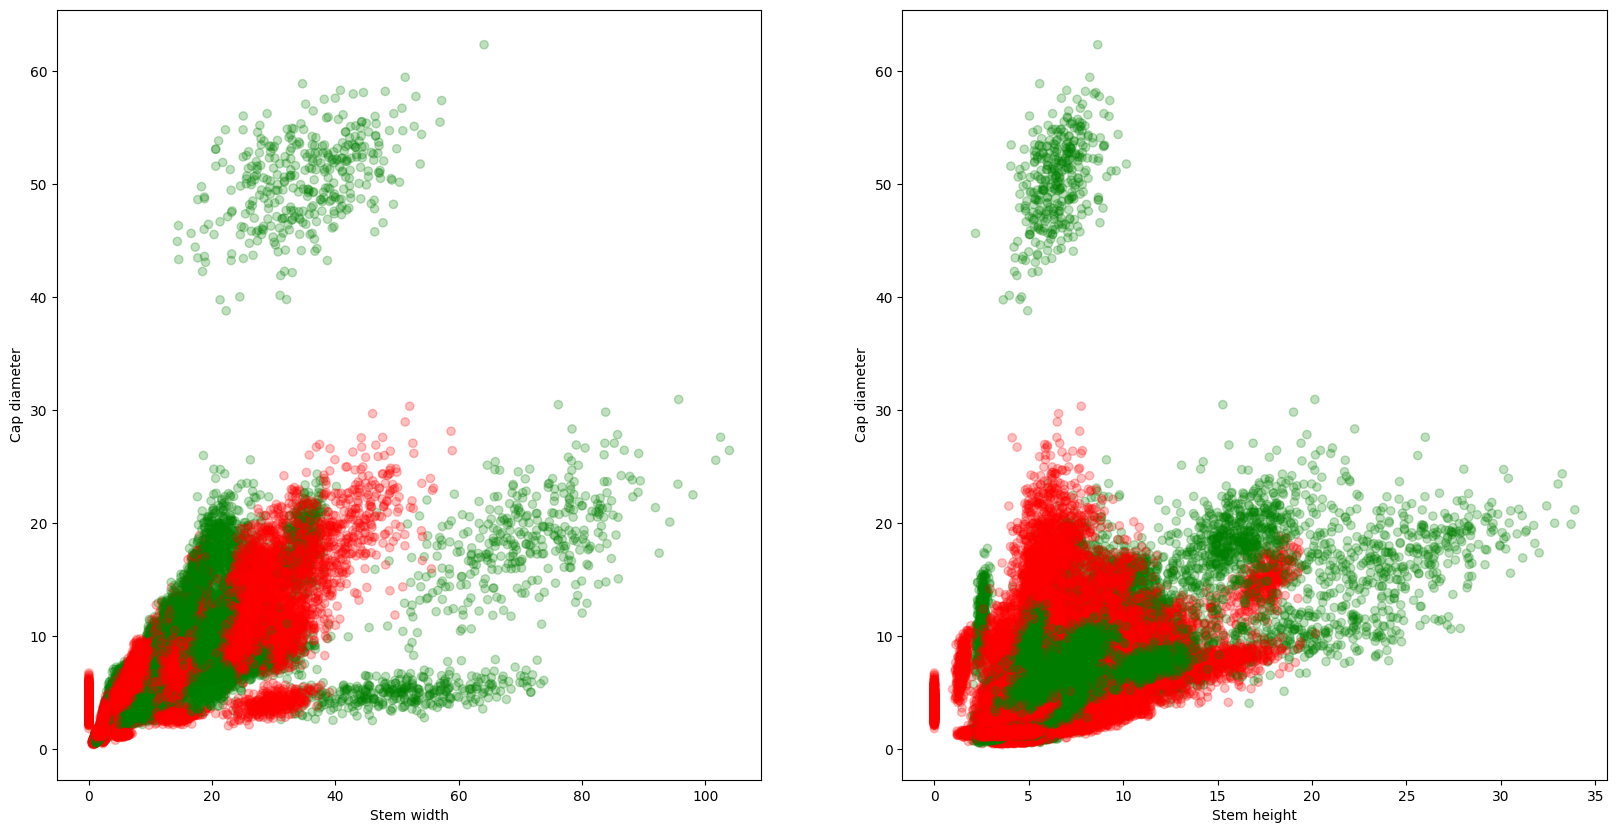

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

axes[0].scatter(mushrooms["stem-width"], mushrooms["cap-diameter"], c=mushrooms["is-edible"].map(is_edible_colors_map), alpha=0.25)
axes[0].set_xlabel("Stem width")
axes[0].set_ylabel("Cap diameter")

axes[1].scatter(mushrooms["stem-height"], mushrooms["cap-diameter"], c=mushrooms["is-edible"].map(is_edible_colors_map), alpha=0.25)
axes[1].set_xlabel("Stem height")
axes[1].set_ylabel("Cap diameter")

funzione da usare figa

In [66]:
def plot_feature_against_is_edible_on_hist(feature, feature_values, ax):
    is_not_edible = mushrooms[mushrooms["is-edible"] == False][feature].dropna()
    is_edible = mushrooms[mushrooms["is-edible"] == True][feature].dropna()

    unique_values = pd.Series(mushrooms[feature].unique()).dropna()
    is_not_edible_value_counts = pd.DataFrame(is_not_edible.value_counts())
    is_edible_value_counts = pd.DataFrame(is_edible.value_counts())

    for unique_value in unique_values:
        if unique_value not in is_not_edible_value_counts.index:
            is_not_edible_value_counts.loc[unique_value] = 0
        if unique_value not in is_edible_value_counts.index:
            is_edible_value_counts.loc[unique_value] = 0

    is_not_edible_value_counts.sort_index(inplace=True)
    is_edible_value_counts.sort_index(inplace=True)

    hist_data = [
        {
            "label": 'Not edible',
            "data": is_not_edible_value_counts["count"],
            "color": is_edible_colors_map[False]
        },
        {
            "label": 'Edible',
            "data": is_edible_value_counts["count"],
            "color": is_edible_colors_map[True]
        }
    ]

    x = np.arange(len(feature_values))
    bars_width = len(feature_values) / figsize[0]

    for i in range(len(hist_data)):
        offset = bars_width * i
        ax.bar_label(ax.bar(x + offset, hist_data[i]["data"], bars_width, label=hist_data[i]["label"], color=hist_data[i]["color"]))

    ax.set_xticks(x + (bars_width / 2), feature_values)
    ax.legend()

Gill attachment

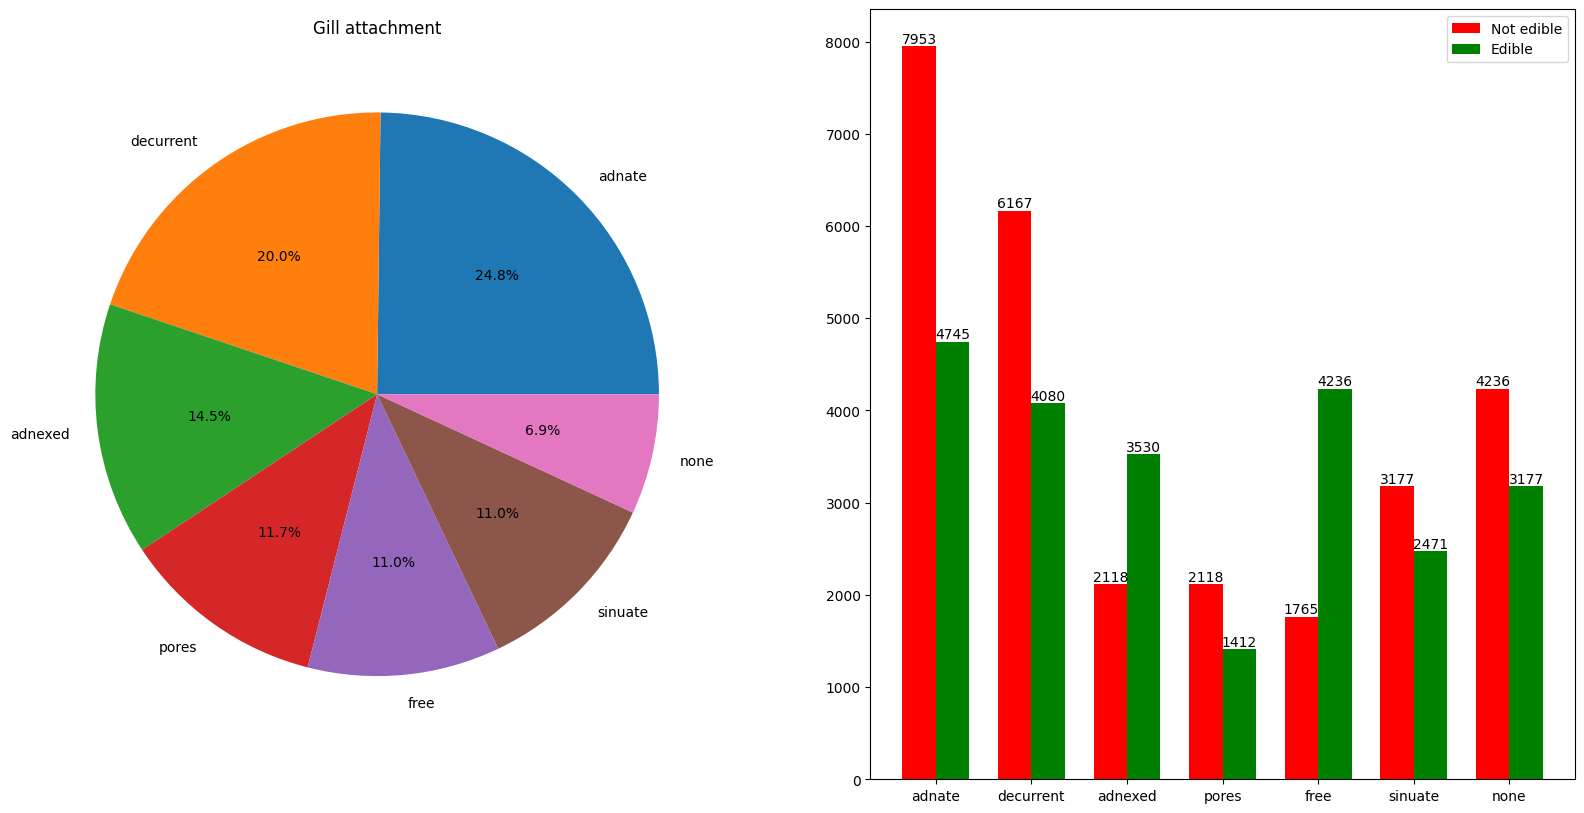

In [67]:
gill_attachment_values = ["adnate", "decurrent", "adnexed", "pores", "free", "sinuate", "none"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

mushrooms["gill-attachment"].value_counts().plot.pie(title="Gill attachment", labels=gill_attachment_values, autopct="%1.1f%%", ylabel="", ax=axes[0])

plot_feature_against_is_edible_on_hist("gill-attachment", gill_attachment_values, axes[1])

season

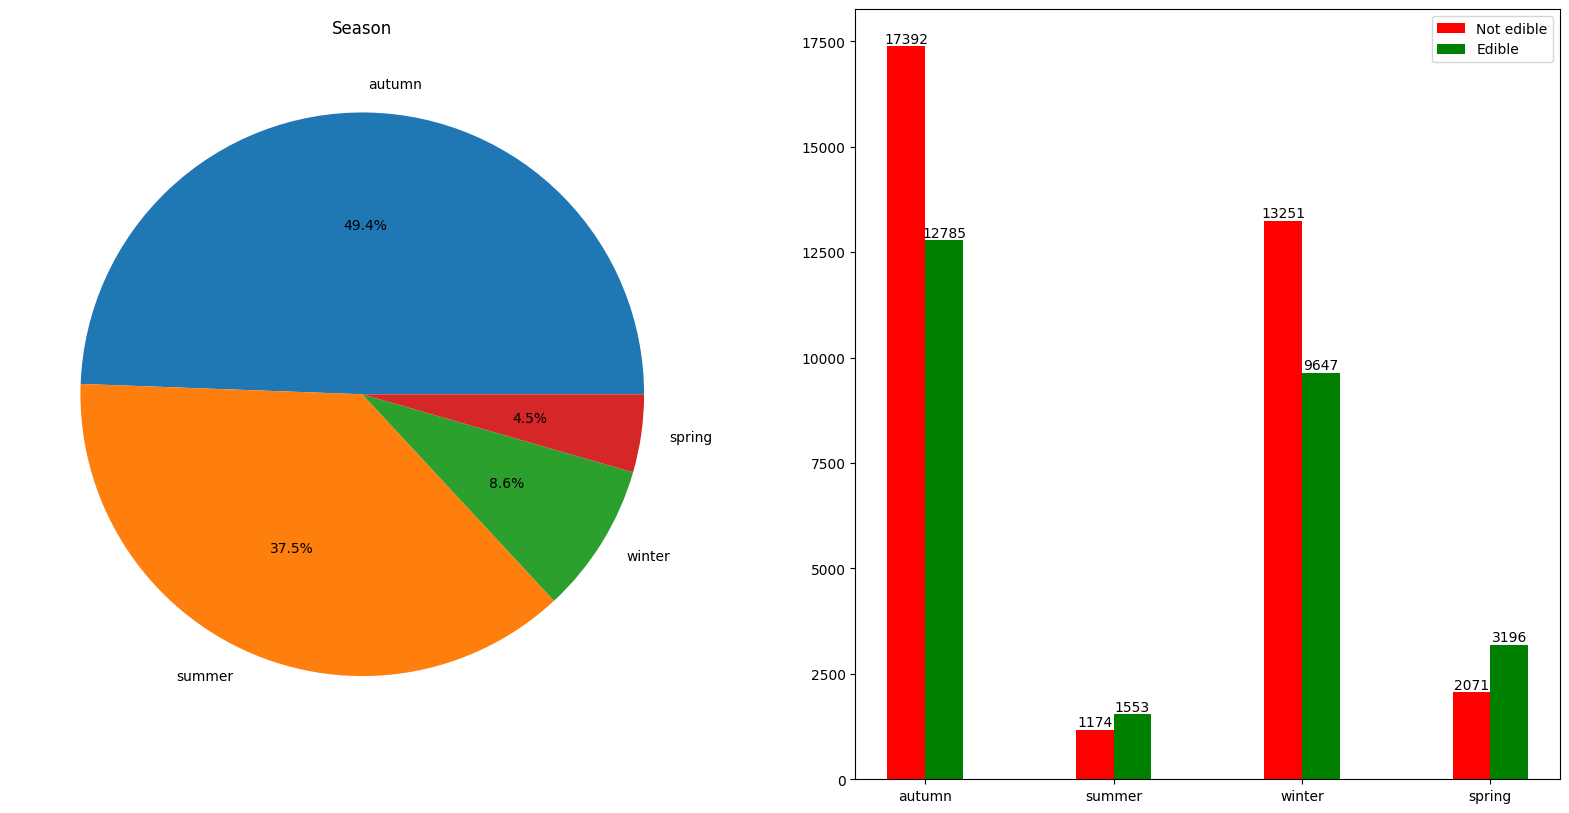

In [68]:
season_values = ["autumn", "summer", "winter", "spring"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

mushrooms["season"].value_counts().plot.pie(title="Season", labels=season_values, autopct="%1.1f%%", ylabel="", ax=axes[0])

plot_feature_against_is_edible_on_hist("season", season_values, axes[1])

veil color

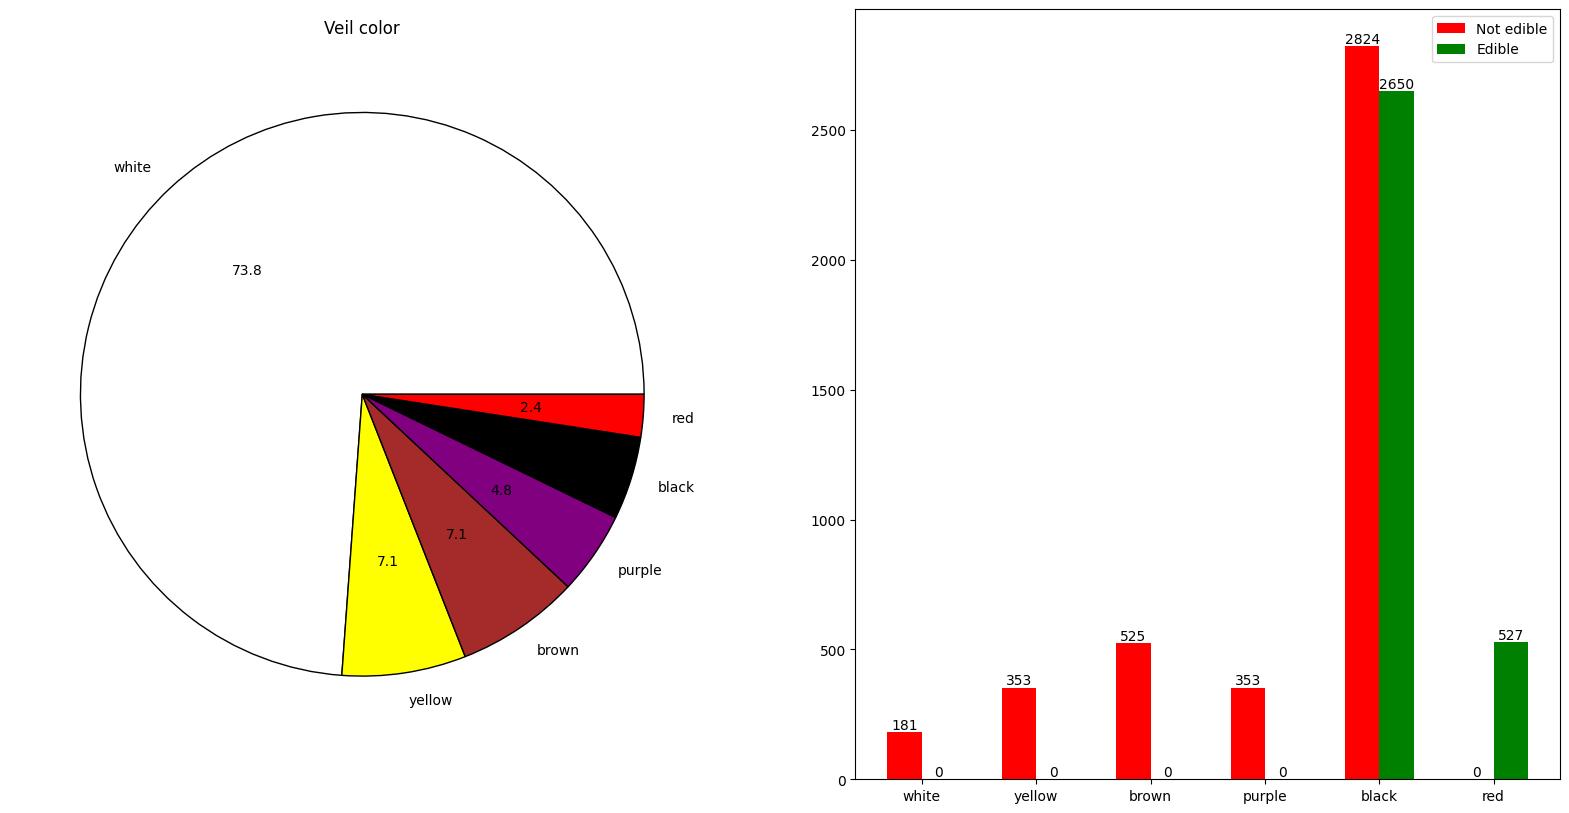

In [69]:
veil_color_values = ["white", "yellow", "brown", "purple", "black", "red"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

axes[0].pie(mushrooms["veil-color"].value_counts(), labels=veil_color_values, colors=veil_color_values, autopct="%1.1f", wedgeprops={"edgecolor": "black"}, textprops={"color": "black"})
axes[0].set_title("Veil color")

plot_feature_against_is_edible_on_hist("veil-color", veil_color_values, axes[1])

veil type

In [70]:
print(mushrooms["veil-type"].value_counts())

mushrooms.drop(columns=["veil-type"], inplace=True)

veil-type
0.0    3177
Name: count, dtype: int64


Distribution

Text(0.5, 1.0, 'Cap Shape Boxplot')

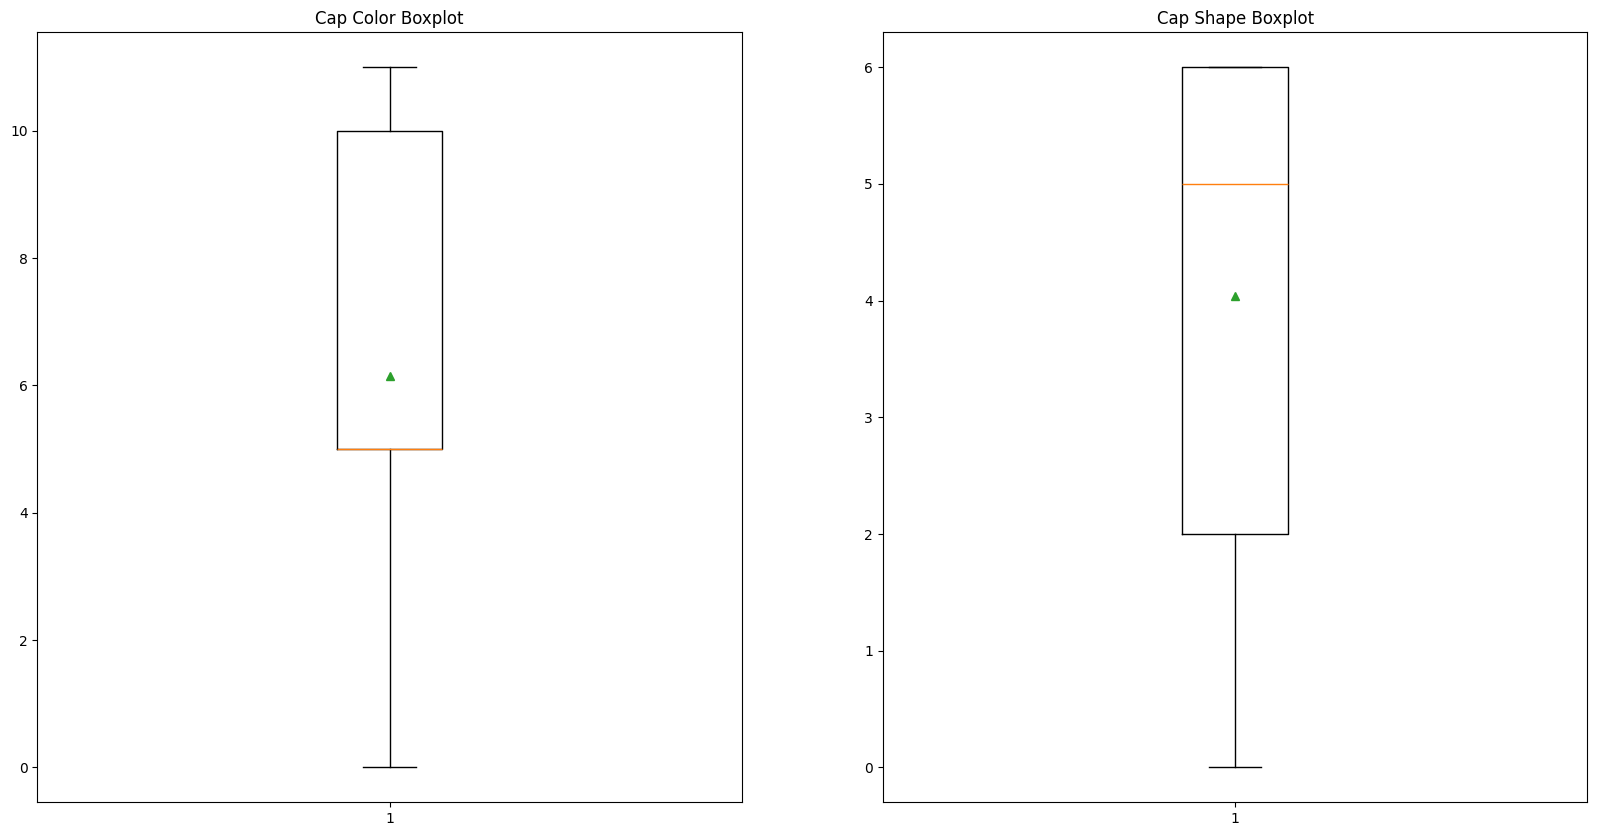

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

axes[0].boxplot(mushrooms["cap-color"], showmeans=True)
axes[0].set_title("Cap Color Boxplot")

axes[1].boxplot(mushrooms["cap-shape"], showmeans=True)
axes[1].set_title("Cap Shape Boxplot")

#### Riempimento valori nulli
Creaiamo una funzione per vedere come sono 

In [72]:
def print_na_percentages(df):
    print(df.isna().sum() / df.shape[0] * 100)

print_na_percentages(mushrooms)

is-edible                0.000000
cap-diameter             0.000000
cap-shape                0.000000
cap-surface             23.121387
cap-color                0.000000
does-bruise-or-bleed     0.000000
gill-attachment         16.184971
gill-spacing            41.040462
gill-color               0.000000
stem-height              0.000000
stem-width               0.000000
stem-root               84.393064
stem-surface            62.427746
stem-color               0.000000
veil-color              87.861272
has-ring                 0.000000
ring-type                4.046243
spore-print-color       89.595376
habitat                  0.000000
season                   0.000000
dtype: float64


Eliminiamo tutte le righe che hanno valori nulli su tutte quelle colonne e ricontrolilamo

In [73]:
if delete_rows_that_have_columns_with_many_nan:
    columns_with_many_nan = [column for column in mushrooms.columns if mushrooms[column].isna().mean() > 0.80]
    mushrooms.dropna(subset=columns_with_many_nan, how='all', inplace=True)

    print_na_percentages(mushrooms)

is-edible                0.000000
cap-diameter             0.000000
cap-shape                0.000000
cap-surface             23.076923
cap-color                0.000000
does-bruise-or-bleed     0.000000
gill-attachment         23.076923
gill-spacing            51.923077
gill-color               0.000000
stem-height              0.000000
stem-width               0.000000
stem-root               48.076923
stem-surface            61.538462
stem-color               0.000000
veil-color              59.615385
has-ring                 0.000000
ring-type                7.692308
spore-print-color       65.384615
habitat                  0.000000
season                   0.000000
dtype: float64


Riempimamo i valori rimasti con Single o KNN e verifichiamo che non siano null

In [74]:
columns_to_fill = mushrooms.columns[mushrooms.isna().any()]

imputer = KNNImputer() if use_knn_imputer else SimpleImputer(strategy="mean")
mushrooms[columns_to_fill] = imputer.fit_transform(mushrooms[columns_to_fill])

print_na_percentages(mushrooms)

is-edible               0.0
cap-diameter            0.0
cap-shape               0.0
cap-surface             0.0
cap-color               0.0
does-bruise-or-bleed    0.0
gill-attachment         0.0
gill-spacing            0.0
gill-color              0.0
stem-height             0.0
stem-width              0.0
stem-root               0.0
stem-surface            0.0
stem-color              0.0
veil-color              0.0
has-ring                0.0
ring-type               0.0
spore-print-color       0.0
habitat                 0.0
season                  0.0
dtype: float64


vediamo memoria

In [75]:
mushrooms.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 18356 entries, 0 to 58244
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   is-edible             18356 non-null  bool   
 1   cap-diameter          18356 non-null  float64
 2   cap-shape             18356 non-null  float64
 3   cap-surface           18356 non-null  float64
 4   cap-color             18356 non-null  float64
 5   does-bruise-or-bleed  18356 non-null  bool   
 6   gill-attachment       18356 non-null  float64
 7   gill-spacing          18356 non-null  float64
 8   gill-color            18356 non-null  float64
 9   stem-height           18356 non-null  float64
 10  stem-width            18356 non-null  float64
 11  stem-root             18356 non-null  float64
 12  stem-surface          18356 non-null  float64
 13  stem-color            18356 non-null  float64
 14  veil-color            18356 non-null  float64
 15  has-ring              18

Describe

In [76]:
mushrooms.describe()

,cap-diameter,cap-shape,cap-surface,cap-color,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-color,ring-type,spore-print-color,habitat,season
count,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000
mean,7.491805,4.197919,5.311048,5.597352,3.139551,0.238832,7.500054,8.066530,13.301566,1.886348,4.388124,8.425528,3.650774,2.005361,2.303955,0.544236,1.074036
std,4.258446,2.157740,2.804397,2.995930,2.150152,0.577965,3.047370,4.310421,9.738472,1.694892,2.210359,3.231006,0.942585,1.983026,1.835574,1.070520,1.118683
min,0.440000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.040000,2.000000,3.000000,5.000000,1.750000,0.000000,5.000000,5.540000,6.660000,0.000000,3.000000,6.000000,3.200000,1.000000,1.000000,0.000000,0.000000
50%,6.970000,6.000000,5.600000,5.000000,3.000000,0.000000,10.000000,7.600000,12.340000,2.000000,5.000000,11.000000,4.000000,1.000000,1.400000,0.000000,1.000000
75%,9.500000,6.000000,7.000000,8.000000,5.000000,0.000000,10.000000,10.040000,17.760000,4.000000,7.000000,11.000000,4.000000,2.200000,3.000000,1.000000,2.000000
max,25.980000,6.000000,10.000000,11.000000,6.000000,2.000000,11.000000,33.920000,73.800000,4.000000,7.000000,12.000000,5.000000,7.000000,6.000000,4.000000,3.000000


#### Altri miglioramenti
verifichiamo che non ci siano colonne con 99% valori uguali

In [77]:
sel = VarianceThreshold(threshold=0.01)
sel.fit(mushrooms)

[column for column in mushrooms.columns if column not in sel.get_feature_names_out()]

[]

Normalizziamo i dati, tipo di normalizzazione

In [78]:
if normalize_data:
    float_columns = mushrooms.select_dtypes(include="float64").columns

    normalizer = Normalizer(norm="l2")
    mushrooms[float_columns] = normalizer.fit_transform(mushrooms[float_columns])

describe finale

In [79]:
mushrooms.describe()

,cap-diameter,cap-shape,cap-surface,cap-color,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-color,ring-type,spore-print-color,habitat,season
count,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000
mean,0.275004,0.172617,0.223861,0.226669,0.135655,0.011656,0.299360,0.302689,0.451448,0.079990,0.175085,0.331510,0.154415,0.080686,0.093974,0.022830,0.044945
std,0.098764,0.103296,0.135283,0.125685,0.109203,0.035585,0.124268,0.129609,0.218921,0.077530,0.091321,0.128705,0.070543,0.079636,0.078808,0.042524,0.051986
min,0.023491,0.000000,0.000000,0.000000,0.000000,0.000000,0.021357,0.000000,0.000000,0.000000,0.000000,0.043590,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.211832,0.085463,0.111043,0.143005,0.054513,0.000000,0.206995,0.232962,0.324023,0.000000,0.116935,0.236173,0.115602,0.035750,0.037207,0.000000,0.000000
50%,0.275934,0.182724,0.230918,0.209274,0.094151,0.000000,0.304546,0.291752,0.472842,0.084305,0.182476,0.343790,0.143926,0.054116,0.061377,0.000000,0.036231
75%,0.339892,0.239657,0.302835,0.310147,0.222868,0.000000,0.379042,0.368535,0.602336,0.138952,0.239261,0.412788,0.183231,0.094335,0.147312,0.043300,0.081774
max,0.605816,0.499362,0.634166,0.716148,0.482717,0.204844,0.671950,0.723695,0.977291,0.329407,0.442405,0.674974,0.452976,0.396453,0.367227,0.231429,0.292932


## Feature selection
Creiamo x e y

In [80]:
y = mushrooms["is-edible"]
X_all = mushrooms.drop(columns="is-edible")

due parole su selectkbest

In [81]:
if k_best_features_to_select > 0:
    selector = SelectKBest(k=k_best_features_to_select)
    best_features = selector.fit_transform(X_all, y)

    X = pd.DataFrame(best_features, columns=selector.get_feature_names_out())
else:
    X = X_all

Standardizziamo X

In [82]:
if standardize_data:
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X[X.columns])

vediamo lavoro finale

In [83]:
X.describe()

,cap-diameter,gill-attachment,stem-width,stem-root,ring-type
count,1.835600e+04,1.835600e+04,1.835600e+04,1.835600e+04,1.835600e+04
mean,-6.812787e-17,-1.858033e-16,2.848984e-16,-4.954754e-17,1.261914e-16
std,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00
min,-2.546662e+00,-1.242262e+00,-2.062207e+00,-1.031764e+00,-1.013223e+00
25%,-6.396391e-01,-7.430540e-01,-5.820743e-01,-1.031764e+00,-5.642956e-01
50%,9.420847e-03,-3.800756e-01,9.773108e-02,5.566032e-02,-3.336646e-01
75%,6.570206e-01,7.986631e-01,6.892562e-01,7.605314e-01,1.713884e-01
max,3.349601e+00,3.178231e+00,2.402045e+00,3.217151e+00,3.965249e+00


## Modello

### Dati di allenamento

6/9 dei dati per training

2/9 dei dati per validazione

1/9 dei dati per test finale

In [84]:
X_train, X_extra, y_train, y_extra = train_test_split(
    X, y,
    test_size=1/3,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X, y,
    test_size=1/3,
    random_state=42
)

Kfold cross validation

In [85]:
skf = StratifiedKFold(3, shuffle=True, random_state=42)

### Scelta del modello

Creiamo una funzione che valuti il risultato prodotto da un modello

In [86]:
def print_eval(X, y, model):
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy/Score: {accuracy:.5}")

    print("Classification report")
    print(classification_report(y, y_pred))

    cm = confusion_matrix(y, y_pred, labels=model.classes_)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()

grid search setup

In [87]:
def grid_search_fit_and_print(X_train, y_train, model, grid):
    grid_search = GridSearchCV(model, grid, cv=skf, scoring="accuracy")
    grid_search.fit(X_train, y_train)
    display(pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score").head(5))
    return grid_search

#### Log reg
solver saga

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__fit_intercept,param_lr__penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.019380,0.001734,0.002011,0.000142,True,l1,"{'lr__fit_intercept': True, 'lr__penalty': 'l1'}",0.781319,0.787203,0.786467,0.784996,0.002618,1
2,0.017668,0.001685,0.001897,0.000059,True,l2,"{'lr__fit_intercept': True, 'lr__penalty': 'l2'}",0.781319,0.786958,0.786467,0.784915,0.002550,2
1,0.019091,0.001548,0.002037,0.000030,False,l1,"{'lr__fit_intercept': False, 'lr__penalty': 'l1'}",0.764158,0.769306,0.761951,0.765139,0.003082,3
0,0.019480,0.001008,0.002492,0.000462,False,l2,"{'lr__fit_intercept': False, 'lr__penalty': 'l2'}",0.764158,0.769306,0.761951,0.765139,0.003082,3


Accuracy/Score: 0.78524
Classification report
              precision    recall  f1-score   support

       False       0.83      0.82      0.83      7716
        True       0.70      0.72      0.71      4521

    accuracy                           0.79     12237
   macro avg       0.77      0.77      0.77     12237
weighted avg       0.79      0.79      0.79     12237



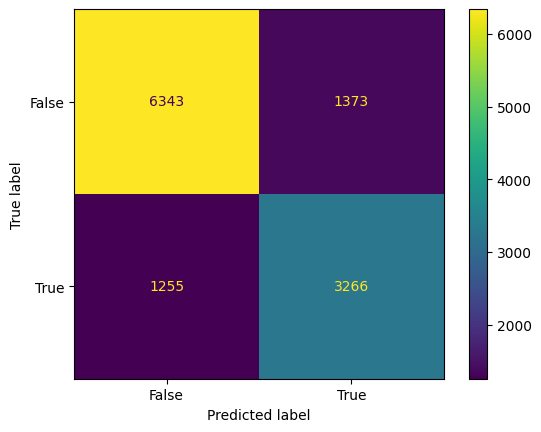

In [88]:
logreg_model = Pipeline([("lr", LogisticRegression(solver="saga", random_state=42))])
logreg_grid = {
    "lr__penalty": ["l2", "l1"],
    "lr__fit_intercept": [False, True]
}

logreg_grid_search = grid_search_fit_and_print(X_train, y_train, logreg_model, logreg_grid)
print_eval(X_val, y_val, logreg_grid_search)

#### Decision Tree

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dtc__criterion,param_dtc__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015719,0.000104,0.002410,0.000101,gini,2,"{'dtc__criterion': 'gini', 'dtc__min_samples_s...",0.834763,0.841873,0.833538,0.836725,0.003675,1
1,0.013800,0.000075,0.002016,0.000041,gini,3,"{'dtc__criterion': 'gini', 'dtc__min_samples_s...",0.834763,0.841873,0.833538,0.836725,0.003675,1
2,0.013766,0.000085,0.001960,0.000016,gini,4,"{'dtc__criterion': 'gini', 'dtc__min_samples_s...",0.834763,0.841873,0.833538,0.836725,0.003675,1
3,0.017084,0.000531,0.002153,0.000120,entropy,2,"{'dtc__criterion': 'entropy', 'dtc__min_sample...",0.823486,0.823731,0.820789,0.822669,0.001333,4
4,0.016869,0.000476,0.002104,0.000120,entropy,3,"{'dtc__criterion': 'entropy', 'dtc__min_sample...",0.823486,0.823731,0.820789,0.822669,0.001333,4


Accuracy/Score: 0.83485
Classification report
              precision    recall  f1-score   support

       False       0.98      0.75      0.85      7716
        True       0.70      0.97      0.81      4521

    accuracy                           0.83     12237
   macro avg       0.84      0.86      0.83     12237
weighted avg       0.88      0.83      0.84     12237



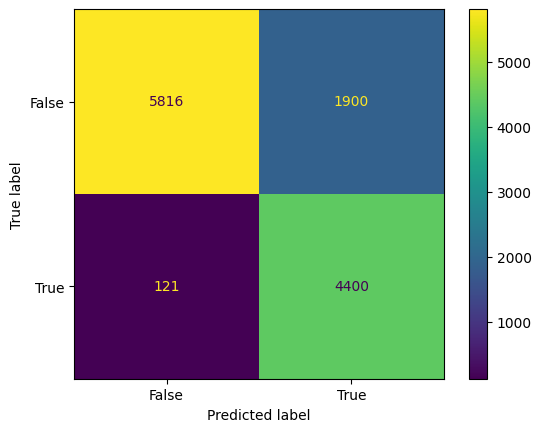

In [89]:
tree_model = Pipeline([("dtc", DecisionTreeClassifier(max_depth=3, random_state=42))])
tree_grid = {
    'dtc__criterion': ['gini', 'entropy'],
    'dtc__min_samples_split': range(2, 5),
}

tree_grid_search = grid_search_fit_and_print(X_train, y_train, tree_model, tree_grid)
print_eval(X_val, y_val, tree_grid_search)

#### Random forest

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__criterion,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.653226,0.033659,0.018703,0.000295,gini,80,"{'rf__criterion': 'gini', 'rf__n_estimators': 80}",0.995342,0.992890,0.990929,0.993054,0.001805,1
1,0.749540,0.045221,0.022567,0.003392,gini,90,"{'rf__criterion': 'gini', 'rf__n_estimators': 90}",0.995342,0.992645,0.991174,0.993054,0.001726,1
2,0.778703,0.002905,0.022233,0.000123,gini,100,"{'rf__criterion': 'gini', 'rf__n_estimators': ...",0.995097,0.992645,0.991419,0.993054,0.001529,1
3,0.858950,0.005486,0.024376,0.000214,gini,110,"{'rf__criterion': 'gini', 'rf__n_estimators': ...",0.995097,0.992645,0.991419,0.993054,0.001529,1
4,0.783145,0.038569,0.019363,0.001947,entropy,80,"{'rf__criterion': 'entropy', 'rf__n_estimators...",0.994852,0.992890,0.990439,0.992727,0.001805,5


Accuracy/Score: 1.0
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      7716
        True       1.00      1.00      1.00      4521

    accuracy                           1.00     12237
   macro avg       1.00      1.00      1.00     12237
weighted avg       1.00      1.00      1.00     12237



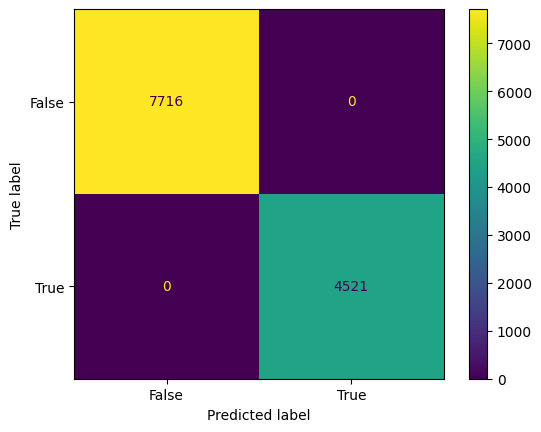

In [90]:
random_forest_model = Pipeline([("rf", RandomForestClassifier(random_state=42))])
random_forest_grid = {
    'rf__criterion': ['gini', 'entropy'],
    'rf__n_estimators': range(80, 120, 10),
}

random_forest_grid_search = grid_search_fit_and_print(X_train, y_train, random_forest_model, random_forest_grid)
print_eval(X_val, y_val, random_forest_grid_search)

#### KNN Classifier

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.004750,0.000085,0.016929,0.000072,4,distance,"{'knn__n_neighbors': 4, 'knn__weights': 'dista...",0.996323,0.994852,0.993871,0.995015,0.001008,1
1,0.004865,0.000101,0.016027,0.000049,3,distance,"{'knn__n_neighbors': 3, 'knn__weights': 'dista...",0.995587,0.994361,0.994116,0.994688,0.000643,2
0,0.005239,0.000207,0.185781,0.011446,3,uniform,"{'knn__n_neighbors': 3, 'knn__weights': 'unifo...",0.995342,0.994607,0.993871,0.994607,0.000601,3
5,0.005385,0.000359,0.019141,0.000430,5,distance,"{'knn__n_neighbors': 5, 'knn__weights': 'dista...",0.996568,0.994361,0.992890,0.994607,0.001511,4
7,0.004851,0.000020,0.019392,0.000232,6,distance,"{'knn__n_neighbors': 6, 'knn__weights': 'dista...",0.996077,0.994607,0.992890,0.994525,0.001302,5


Accuracy/Score: 1.0
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      7716
        True       1.00      1.00      1.00      4521

    accuracy                           1.00     12237
   macro avg       1.00      1.00      1.00     12237
weighted avg       1.00      1.00      1.00     12237



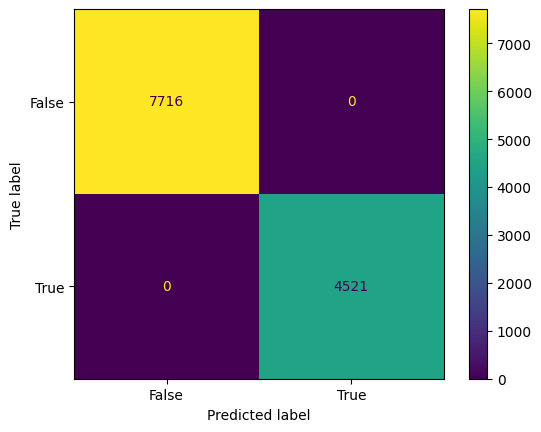

In [91]:
knn_model = Pipeline([("knn", KNeighborsClassifier())])
knn_grid = {
    'knn__n_neighbors': range(3, 7),
    'knn__weights': ['uniform', 'distance']
}

knn_grid_search = grid_search_fit_and_print(X_train, y_train, knn_model, knn_grid)
print_eval(X_val, y_val, knn_grid_search)

### Validazione
#### confronto con dummy classifer

Accuracy/Score: 0.63055
Classification report
              precision    recall  f1-score   support

       False       0.63      1.00      0.77      7716
        True       0.00      0.00      0.00      4521

    accuracy                           0.63     12237
   macro avg       0.32      0.50      0.39     12237
weighted avg       0.40      0.63      0.49     12237



/Users/mauropellonara/Documents/mushrooms-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mauropellonara/Documents/mushrooms-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mauropellonara/Documents/mushrooms-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

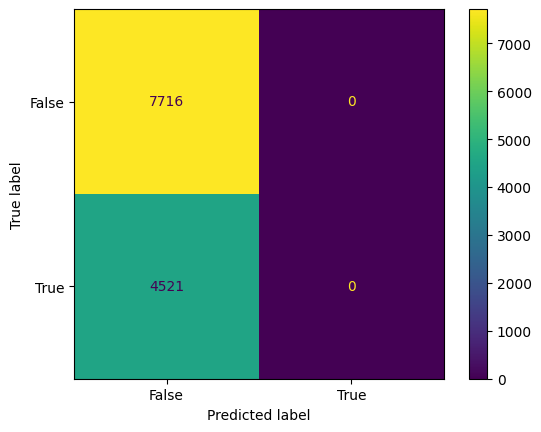

In [92]:
dummy_model = DummyClassifier(random_state=42)
dummy_model.fit(X_train, y_train)

print_eval(X_val, y_val, dummy_model)

#### Precision recall curve
dei 3 migliori sempre

In [93]:
precision_rf, recall_rf, _ = precision_recall_curve(y_val, random_forest_grid_search.predict_proba(X_val)[:, 1])
precision_knn, recall_knn, _ = precision_recall_curve(y_val, knn_grid_search.predict_proba(X_val)[:, 1])
precision_logreg, recall_logreg, _ = precision_recall_curve(y_val, logreg_grid_search.predict_proba(X_val)[:, 1])

Mostriamo

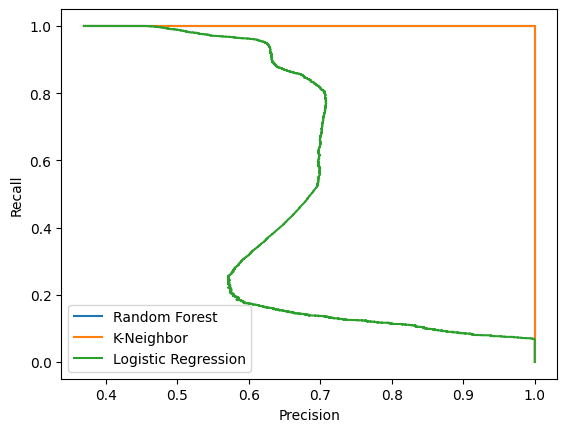

In [94]:
plt.plot(precision_rf, recall_rf, label="Random Forest")
plt.plot(precision_knn, recall_knn, label="K-Neighbor")
plt.plot(precision_logreg, recall_logreg, label="Logistic Regression")

plt.xlabel("Precision")
plt.ylabel("Recall")

plt.legend(loc="lower left")

#### Overfitting
con test data mai visto prima e mai usato per validazione

Accuracy/Score: 0.99444
Classification report
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      3933
        True       0.99      0.99      0.99      2186

    accuracy                           0.99      6119
   macro avg       0.99      0.99      0.99      6119
weighted avg       0.99      0.99      0.99      6119



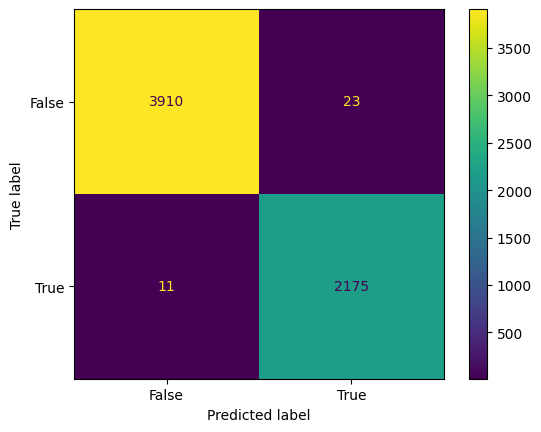

In [95]:
print_eval(X_test, y_test, random_forest_grid_search)

## Conclusioni
If you don't normalize the data and you keep 7+ features than you will still get to 100% accuracy
But if you want to lower the amount of features to below 5 than normalizing data improves the accuracy quite a bit

It's also nice to reduce the number of selected features as it makes the real life application more reasonable

Removing all those rows with NaN values in those 4 columns improves the quality of data a lot, and we still come out with 18k rows of valuable data. Less data filling -> better quality of data -> faster training